In [2]:
# Preamble
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

# Almost-scaled dot product attention

The transformer model architecture is ubiquitous, but we don't fully understand how it works, or what makes it so effective. At the heart of the transformer is scaled dot product attention. While working on [Unit Scaling](https://arxiv.org/abs/2303.11257), we noticed something interesting:

Many deep learning modules are designed and initialised to roughly preserve variance in the forward and/or backward (gradient) passes. Dot product [attention](https://arxiv.org/abs/1706.03762) explicitly includes a scaling factor for this (it's $\sqrt{1/d_h}$ if you're already familiar, but we'll explain this as we go.) But this is **not enough for attention to preserve variance**. Let's see what is.

In this post, we'll pick apart the scaling behaviour of attention, and propose a new scaling factor. Here's what to expect:

1. [Hey attention, how's scaling?](#1.-Hey-attention,-how's-scaling?)
2. [Attention: flat, spiky or LogNormal.](#2.-Attention:-flat,-spiky-or-LogNormal.)
3. [Fully-scaled dot product self attention](#3.-Fully-scaled-dot-product-attention)
4. [Properly scaled, properly broken.](#4.-Properly-scaled,-properly-broken.)
5. [What did I learn?](#5.-What-did-I-learn?)

This is a long-ish, somewhat mathsy article, so if you want to skip to the answer, that's part [3](#3.-Fully-scaled-dot-product-attention), but make sure you read why you shouldn't use it in part [4](#4.-Properly-scaled,-properly-broken.), before blaming us.

---

## 1. Hey attention, how's scaling?

Here's an expression for non-causal scaled dot product attention (the core, excluding input and output projections):

$O = \mathrm{Attention}(Q, K, V) \;\textrm{where}\; \{Q,K,V,O\} \in \mathcal{R}^{d_s \times d_h}$

defined as:

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V$

Here $Q$, $K$ and $V$ are _queries_, _keys_ and _values_ derived from the input, $d_h$ is the _head size_, and $d_s$ the _sequence length_. We use $A^{\prime}$ for the pre-softmax attention scores matrix. Let's see how well it preserves standard deviation, which we'll refer to as **scale**.

In [3]:
sequence_length = 256  # d_s
head_size = 64         # d_h
n_heads = 2
batch_size = 512

q, k, v = torch.randn(3, batch_size, n_heads, sequence_length, head_size)

pre_a = q @ k.transpose(2, 3) * (head_size ** -0.5)  # 1. Scaled QK matmul
a = torch.softmax(pre_a, dim=-1)                     # 2. Softmax
out = a @ v                                          # 3. AV matmul

for name in ["q", "k", "v", "", "pre_a", "a", "out"]:
    if not name: print(); continue
    var = globals()[name]
    print(f"{name:>8}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

       q:  μ= 0.000, σ=1.000
       k:  μ=-0.000, σ=1.000
       v:  μ=-0.000, σ=1.000

   pre_a:  μ=-0.000, σ=1.000
       a:  μ= 0.004, σ=0.005
     out:  μ=-0.000, σ=0.102


This code generates unit-normal inputs $Q, K, V$ to attention, then prints the mean and scale of intermediate and output tensors $A^{\prime}, A \,(=\!\mathrm{Softmax}(A^{\prime})), O$.

**Step 1 is to compute $Q K^T \cdot d_h^{-1/2}$.**

Here, the scaling factor $d_h^{-1/2}$ is carefully chosen to cancel out an increased scale from the sum of uncorrelated values. Since $\mathbb{E}(Q_{ij} K_{kj}) = 0$ and $\mathbb{E}((Q_{ij} K_{kj})^2) = 1$, the central limit theorem gives $\mathbb{E}((Q K^T)^2) = d_h$. Therefore to keep unit scale, we must multiply by $d_h^{-1/2}$. This ensures that $A^{\prime}$ (`pre_a`), is approximately unit scale.

**Step 2 is softmax over the sequence length.**

Note that the softmax itself cannot preserve unit scale, since the outputs are in the range $[0, 1]$; the highest possible scale would be 1/2. It also cannot ensure zero mean, since it sums to 1 over the target sequence dimension $d_s$, so $\mathbb{E}(A) = d_s^{-1}$.

**Step 3 is to use the attention matrix $A$ to mix the values $V$.**

Following the method of step 1, _if_ the inputs were both zero-mean, unit-scale, we would expect to multiply by $d_s^{-1/2}$ to retain unit scale. However, as we saw in step 2, the $A$ matrix is far from satisfying this assumption. In the example above, this means $O$ (`out`) has a low scale ~0.1, so multiplying by $d_s^{-1/2}$ would move it in entirely the wrong direction.

**To summarise,** although scaled dot product attention includes a scaling factor, it does not deal with all of the scaling behaviour: **attention outputs are under-scaled**.

---

## 2. Attention: flat, spiky or LogNormal.

In this section, we'll try to explain why $O$ is under-scaled in standard attention. We'll first introduce a temperature $t$ into the softmax, as it gives two extreme cases that are a bit simpler to follow, before tackling the more difficult $t=1$ case.

For $x \in \mathcal{R}^{d_s}$, define $\mathrm{Softmax}(x, t)_i = e^{x_i / t} \,/ \sum_j{e^{x_j/t}}$.

---

**2.1 In the extreme $t\to\infty$**, we get $\mathrm{Softmax}(x, t)_i = d_s^{-1}$, which is a flat distribution over attention keys.

Plugging this into attention, we'd expect $\mathbb{E}((A_{ij} V_{jk})^2) = d_s^{-2}$, so $\mathbb{E}((A V)^2) = d_s^{-1}$. Overall, we'd expect $t\to\infty$ attention to have output scale $d_s^{-1/2}$, i.e.

In [4]:
sequence_length ** -0.5

0.0625

This is quite close to 0.1, observed above.

---

**2.2 In the extreme $t\to 0$**, we get $\mathrm{Softmax}(x, t)_i = \mathbb{I}(x_i\!==\!\mathrm{Max}(x))$, which is a unit "spike" on the maximum value of $x$. Since $A$ and $V$ are uncorrelated, the matrix multiplication $A V$ then selects a random value from $V$, therefore $\mathbb{E}((A V)^2) = 1$. Therefore, we'd expect $t\to 0$ attention to have output scale $1$.

---

**2.3 Otherwise**, start by assuming that the values going into the softmax are normally distributed, with scale $1/t$. Then, we rewrite softmax as $\mathrm{Softmax}(x)_i = e^{x_i - \log\sum_j{e^{x_j}}}$. Now we treat the log-sum-exp term as a constant, and will later ensure that the softmax is _normalised in expectation_, so we can say:

$A = e^{A^{\prime}},\; A^{\prime} \sim N(\mu, t^{-2})$

$A$ therefore follows a LogNormal distribution, Given the normalisation-in-expectation constraint $\mathbb{E}(A)=d_s^{-1}$, we can solve for the unknown $\mu$, giving:

$A \sim \mathrm{LogNormal}(-\ln(d_s) - \frac{1}{2}\, t^{-2}, t^{-2})$.

Since we assume $A$ and $V$ are independent, $\mathbb{E}(A_{ij} V_{jk}) = \mathbb{E}(A)\, \mathbb{E}(V) = 0$.

Also, $\mathbb{E}((A_{ij} V_{jk})^2) = \mathbb{E}(A^2)\, \mathbb{E}(V^2) = e^{2\mu + 2\sigma^2} = d_s^{-2}\,e^{t^{-2}}$, so $\mathbb{E}((A V)^2) = d_s^{-1}\,e^{t^{-2}}$.

This predicts an output scale of $d_s^{-1/2}\,e^{t^{-2}/2}$.

---

**Quick check**

Now let's see if these rules work, for $\mathrm{Softmax}(A^{\prime} V)$, in isolation:

In [5]:
def empirical_softmax_std_scaling(sequence_length: int, temperature: float, nelement: int = int(1e7)) -> float:
    pre_a = torch.randn(nelement // sequence_length, sequence_length)
    v = torch.randn(nelement // sequence_length, sequence_length)
    out = (torch.softmax(pre_a / temperature, -1) * v).sum(-1)
    return out.std()

def lognormal_softmax_std_scaling(sequence_length: int, temperature: float) -> float:
    return torch.minimum(torch.tensor(1), sequence_length ** -0.5 * torch.exp(temperature ** -2 / 2))

Hopefully no surprises in the implementation of the above. Let's see how it works as we vary temperature:

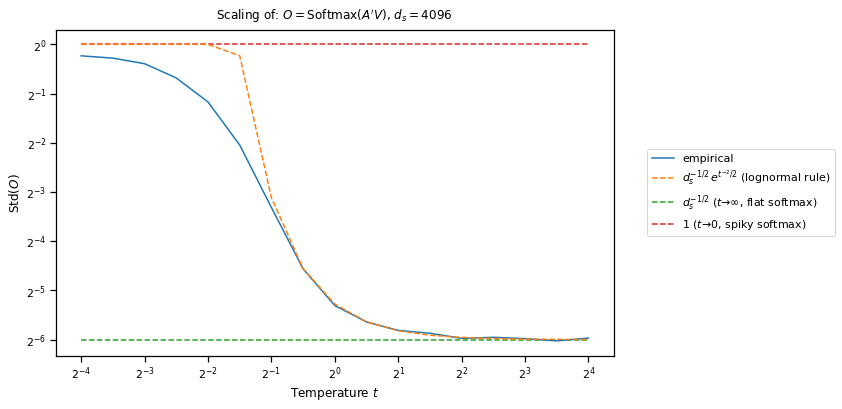

In [6]:
temperatures = 2 ** torch.arange(-4, 4.01, 0.5)
sequence_length = 4096

empirical_scaling = [empirical_softmax_std_scaling(sequence_length=sequence_length, temperature=t) for t in temperatures]
lognormal_scaling = lognormal_softmax_std_scaling(sequence_length=sequence_length, temperature=temperatures)
temperature_inf_scaling = sequence_length ** -0.5
temperature_zero_scaling = 1.0

plt.figure(figsize=(10, 6)) ; c = iter(sns.color_palette())
plt.plot(temperatures, empirical_scaling, color=next(c), label="empirical")
plt.plot(temperatures, lognormal_scaling, color=next(c),
         linestyle="dashed", label="$d_s^{-1/2}\, e^{t^{-2} / 2}$ (lognormal rule)")
plt.hlines(temperature_inf_scaling, temperatures.min(), temperatures.max(),
           color=next(c), linestyle="dashed", label=r"$d_s^{-1/2}$ ($t\to\infty$, flat softmax)")
plt.hlines(temperature_zero_scaling, temperatures.min(), temperatures.max(),
           color=next(c), linestyle="dashed", label=r"$1$ ($t\to 0$, spiky softmax)")
plt.xscale("log", base=2) ; plt.yscale("log", base=2)
plt.xlabel("Temperature $t$") ; plt.ylabel(r"$\mathrm{Std}(O)$")
plt.xticks(2**torch.arange(-4, 4.01)) ; plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.title(f"Scaling of: $O = \mathrm{{Softmax}}(A^{{\prime}} V)$, $d_s={sequence_length}$", pad=10);

That's not too bad. Our $t\to\infty$ and $t\to 0$ rules give the right asymptotes, and the lognormal rule seems to work OK for $t\ge\frac{1}{2}$. We expect the lognormal breakdown is due to the fact that our model only normalises the softmax in expectation, whereas the true softmax will normalise over a finite set of samples.

Now we're fully equipped with a scaling model that should let us "fix" attention's forward pass.

---

# 3. Fully-scaled dot product attention

We just saw that the pre-softmax scaling of dot product attention works as expected, but that we need to add an additional post-softmax scale factor if we want to prevent scale from shrinking through attention as a whole. Without a scale factor, we expect unit-scaled inputs to produce outputs of scale $(e/d_s)^{1/2}$.

To counteract this, we can modify the scaled attention equation thus:

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\cdot (d_s/e)^{1/2}}$

Let's implement & sanity-check:

In [7]:
sequence_length = 256  # d_s
head_size = 64         # d_h
n_heads = 2
batch_size = 512

q, k, v = torch.randn(3, batch_size, n_heads, sequence_length, head_size)

pre_a = q @ k.transpose(2, 3) * (head_size ** -0.5)  # 1. Scaled QK matmul
a = torch.softmax(pre_a, dim=-1)                     # 2. Softmax
out = a @ v * (sequence_length / np.e) ** 0.5        # 3. Scaled AV matmul (NEW)

for name in ["q", "k", "v", "", "pre_a", "a", "out"]:
    if not name: print(); continue
    var = globals()[name]
    print(f"{name:>8}:  μ={var.mean():>6.3f}, σ={var.std():.3f}")

       q:  μ=-0.000, σ=1.000
       k:  μ= 0.000, σ=1.000
       v:  μ= 0.000, σ=1.000

   pre_a:  μ= 0.000, σ=0.999
       a:  μ= 0.004, σ=0.005
     out:  μ= 0.001, σ=0.994


That's grand—as we hoped, `out` is now roughly unit-scale, so we've found a well-scaled attention "core", hurrah! Note that causal masking and positional encodings may change the scaling behaviour, but we leave these as an exercise for the reader. You can import PyTorch implementations of this & other scaled ops from our [unit-scaling](https://github.com/graphcore-research/unit-scaling) library.

---

# 4. Properly scaled, properly broken.

Let's see what happens if we optimistically implement this "improvement" for the scaling of attention, in a full transformer. To keep things quick and simple, we'll train a small autoregressive byte-level transformer model on the works of Shakespeare.

We're also only interested in training dynamics, not whether this change has an impact on generalisation, so our test metric will be final training loss. We'll use a fixed batch size, number of steps and model size, on the assumption that our scaling change should work over similar ranges as the baseline. However, since we have changed the scaling applied to a subset of the model, we will re-sweep learning rate, as the best learning rate may have changed. Note that the code is tucked away inside the companion module `demo_transformer`, feel free to take a look.

The results:

100%|██████████| 500/500 [00:18<00:00, 27.54it/s]


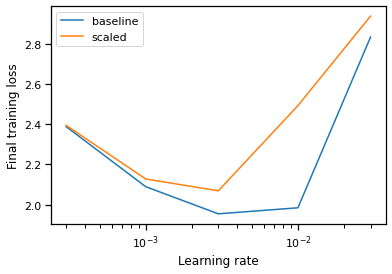

In [18]:
# !wget https://www.gutenberg.org/cache/epub/100/pg100.txt -O shakespare.txt
import demo_transformer

def sweep_lr():
    for lr in [3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
        demo_transformer.CONFIG.lr = lr
        log = demo_transformer.train()
        yield dict(lr=lr, loss=float(log[-20:].mean()))

demo_transformer.CONFIG.fully_scaled_attention = False
baseline_results = list(sweep_lr())
demo_transformer.CONFIG.fully_scaled_attention = True
scaled_results = list(sweep_lr())

for name, data in {"baseline": baseline_results, "fully scaled": scaled_results}.items():
    plt.plot([d["lr"] for d in data], [d["loss"] for d in data], label=name)
plt.xscale("log") ; plt.legend() ; plt.xlabel("Learning rate") ; plt.ylabel("Final training loss");

Awkwardly, fully scaled attention seems worse than the original (under-scaled) baseline.

We haven't reached a full understanding of this effect, but it appears that fully-scaled attention cannot tolerate such a high learning rate as the baseline. This seems plausible, and would imply that the learning dynamics of the attention parameters are less stable (in some sense) than those of the feed-forward layers. Altogether, it's intriguing that the happy conincidence of an under-scaled attention definition has this beneficial impact on training.

> Since unit scaling requires that we get rid of these implicit scaling rules, and keep everything well-scaled, it offers another solution to this problem: to introduce a residual weight when adding the contribution of the attention module to the skip connection from the previous layer. This can be made to have exactly the same effect as the implicit baseline scaling, while keeping intermediate tensors close to unit scale. (It's also the reason we noticed this interesting property of standard attention layers in transformer models.)

---

# 5. What did I learn?

We started by asking the question "why doesn't self-attention preserve unit scale", which took us on a (hopefully stimulating) journey via the LogNormal distribution to a new definition for _fully-scaled dot product attention_. Here it is:

$A^{\prime} = Q K^T \cdot d_h^{-1/2}$

$O = \mathrm{Softmax}(A^{\prime})\, V \color{red}{\cdot (d_s/e)^{1/2}}$

Excitingly, this seemed to do fix the scales, as we'd hoped. Less exciting, but equally interesting: this change seemed to hurt the convergence of an autoregressive transformer model. More work is needed to understand why, but it seems to be connected to a lower maximum learning rate that is tolerated when the weighting of self-attention layers is increased. So, training stability may be improved when the weighting of the pointwise FFN layers (in terms of activation scale) is larger than that of the attention layers.

We'll leave it there for today; may your transformations preserve scale and may your learning dynamics remain stable. If this has piqued your interest, why not take a look at [Unit Scaling](https://arxiv.org/abs/2303.11257) (as a special treat, there's even a nice big table of scaling factors in the Appendix.)